In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.datasets import make_circles, make_moons

import scipy

import torch
import torch.nn as nn
import math

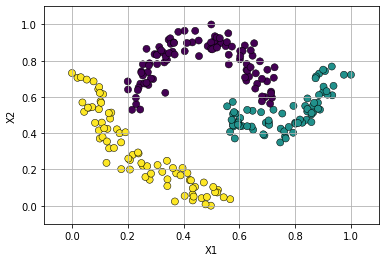

In [2]:
np.random.seed(249) ## 148, 249

xxc, yc = make_circles(n_samples=600, factor=.5,
                                      noise=.09)
idx = yc==0
xxc = xxc[idx]
yc = yc[idx]

idx = (xxc[:,0]+xxc[:,1]<-1)
xxc = xxc[idx]
yc = yc[idx]


xxm, ym = make_moons(n_samples=200, noise=.15)
xxm = xxm/2 - 0.2

msk0 = np.bitwise_and(ym==1 ,xxm[:, 0] > 0)
msk1 = ym==0
msk = msk0 | msk1
xxm = xxm[msk]
ym = ym[msk]

xx = np.concatenate((xxm, xxc), axis=0)
y = np.concatenate((ym, yc+2), axis=0)

## MinMax Normalization
x1 = xx[:,0]
x2 = xx[:,1]
x1 = (x1-x1.min())/(x1.max()-x1.min())
x2 = (x2-x2.min())/(x2.max()-x2.min())
xx = np.column_stack((x1,x2))

%matplotlib inline
plt.scatter(x1, x2, c=y, s=50, edgecolors='k', lw=0.5)

(x1min, x1max) = -0.1, 1.1
plt.xlim((x1min, x1max))
plt.ylim((x1min, x1max))
plt.xlabel("X1")
plt.ylabel('X2')
plt.grid()

In [3]:
## https://see.stanford.edu/materials/aimlcs229/cs229-notes8.pdf
## https://stephens999.github.io/fiveMinuteStats/intro_to_em.html

In [4]:
# inp = torch.randn(200,1)*3-1
# inp = torch.rand(200)*5-1
# inp = torch.tensor(x1, dtype=torch.float32)
# inp = torch.cat([torch.randn(200,1)*1.5-5, torch.randn(200,1)*1+2])
inp = torch.cat([torch.rand(200,1)*3-3, torch.rand(200,1)*2+1])

In [5]:
class Gaussian_MM(nn.Module):
    def __init__(self, num_components):
        super().__init__()
        
        self.num_components = num_components
        self.means = nn.Parameter(torch.randn(self.num_components, dtype=torch.float32))
        self.vars = nn.Parameter(torch.abs(torch.randn(self.num_components, dtype=torch.float32)+1))
        self.pi = nn.Parameter(torch.ones(self.num_components, dtype=torch.float32)/self.num_components)
        
    def gaussian(self, x, mean, var):
        return torch.exp(-0.5*(x-mean)**2/var) / torch.sqrt(2*var*np.pi)
    
    def _nll(self, x, mean, var):
        return -1/(2*var)*((x-mean)**2) - torch.log(var)/2
    
    def forward_probs(self, x):
        self.pi.data /= self.pi.data.sum()
        self.pi.data = self.pi.data.abs()
        probs = []
        for i in range(self.num_components):
            prob = self.gaussian(x, self.means[i], self.vars[i])
            probs.append(self.pi[i]*prob.reshape(1, -1))
        probs = torch.cat(probs, dim=0)
        return probs
    
    def forward(self, x):
        return self.forward_probs(x).sum(dim=0).reshape(-1)
    
    def NLL(self, x):
        self.pi.data /= self.pi.data.sum()
        self.pi.data = self.pi.data.abs()
        
        with torch.no_grad():
            gammas = torch.empty(len(x), self.num_components)
            for i in range(self.num_components):
                pi = self.pi[i] * self.gaussian(x, self.means[i], self.vars[i])
    #             print(pi)
                gammas[:, [i]] = pi.data.reshape(-1, 1)
            
#             print(gammas.shape)
            gammas = gammas/gammas.sum(dim=1, keepdim=True)
#             print(gammas.shape)
#             print(gammas)
        
        tot = 0
        for i in range(self.num_components):
            l = self._nll(x, self.means[i], self.vars[i])
            l = (l + torch.log(self.pi[i]))*gammas[:, [i]]
            tot += l.mean()/self.num_components ### sum is required; 
            ### mean normalizes the likelihood across any number of x and components
        return tot

In [6]:
gaus = Gaussian_MM(2)

In [7]:
gaus.NLL(inp)

tensor(-0.8003, grad_fn=<AddBackward0>)

In [8]:
list(gaus.parameters())

[Parameter containing:
 tensor([-0.5284,  1.0492], requires_grad=True), Parameter containing:
 tensor([1.2071, 1.6394], requires_grad=True), Parameter containing:
 tensor([0.5000, 0.5000], requires_grad=True)]

In [9]:
# optim = torch.optim.SGD(gaus.parameters(), lr=0.1)
optim = torch.optim.Adam(gaus.parameters(), lr=0.01)

In [10]:
for i in range(10000):
    NLL = -gaus.NLL(inp)
    optim.zero_grad()
    NLL.backward()
    optim.step()
    if i%1000 == 0:
        print("NLL: ", float(NLL))
        print(f"Mean: {gaus.means.data}, Variance: {gaus.vars.data}, PI: {gaus.pi.data}")

NLL:  0.8002685308456421
Mean: tensor([-0.5384,  1.0592]), Variance: tensor([1.2171, 1.6494]), PI: tensor([0.5100, 0.5100])
NLL:  0.43364399671554565
Mean: tensor([-1.4502,  1.9632]), Variance: tensor([0.7911, 0.3421]), PI: tensor([0.5114, 0.5086])
NLL:  0.43363156914711
Mean: tensor([-1.4503,  1.9631]), Variance: tensor([0.7910, 0.3421]), PI: tensor([0.5107, 0.5093])
NLL:  0.4336262345314026
Mean: tensor([-1.4503,  1.9631]), Variance: tensor([0.7909, 0.3421]), PI: tensor([0.5104, 0.5096])
NLL:  0.43362343311309814
Mean: tensor([-1.4503,  1.9631]), Variance: tensor([0.7909, 0.3421]), PI: tensor([0.5102, 0.5098])
NLL:  0.43362176418304443
Mean: tensor([-1.4503,  1.9631]), Variance: tensor([0.7909, 0.3421]), PI: tensor([0.5101, 0.5099])
NLL:  0.43362075090408325
Mean: tensor([-1.4503,  1.9631]), Variance: tensor([0.7909, 0.3421]), PI: tensor([0.5101, 0.5099])
NLL:  0.43362027406692505
Mean: tensor([-1.4503,  1.9631]), Variance: tensor([0.7908, 0.3421]), PI: tensor([0.5101, 0.5099])
NLL: 

In [11]:
yout = gaus.forward_probs(inp)

In [12]:
yout.shape

torch.Size([2, 400])

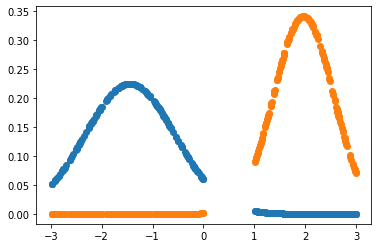

In [13]:
for i in range(gaus.num_components):
    plt.scatter(inp.data.numpy(), yout.data.numpy()[i])

In [14]:
# https://github.com/mhdadk/Maximum-Likelihood-Estimation/blob/master/mle_gaussian.ipynb

## For Bandpass Distribution

In [15]:
# %timeit math.gamma(1/4)

In [16]:
# %timeit scipy.special.gamma(1/4)

In [17]:
# v = torch.tensor([1/4])
# math.gamma(1/4), scipy.special.gamma(1/4), float(torch.lgamma(v).exp()[0])

In [18]:
# %timeit torch.lgamma(v).exp()

In [19]:
class Bandpass_MM(nn.Module):
    def __init__(self, num_components):
        super().__init__()
        
        self.num_components = num_components
        self.means = nn.Parameter(torch.randn(self.num_components, dtype=torch.float32))
        self.vars = nn.Parameter(torch.abs(torch.randn(self.num_components, dtype=torch.float32)+1)*0.4)
        self.powrs = nn.Parameter(torch.ones(self.num_components, dtype=torch.float32))
        self.pi = nn.Parameter(torch.ones(self.num_components, dtype=torch.float32)/self.num_components)
        
    def _bandpass(self, x, mean, var, powr):
#         print(torch.exp(-(((x-mean)**2)*(var**2))**powr)*var*powr\
#               / math.gamma(0.5/float(var)))
        return torch.exp(-(((x-mean)**2)*(var**2))**powr)*var*powr\
                    / math.gamma(0.5/float(powr))
    
    def _nll(self, x, mean, var, powr):
#         t1 = (((x-self.params[0])**2)*(self.params[1]**2))**self.params[2]
#         t2 = torch.log(var*pow)
#         t3 = torch.lgamma(0.5/pow)
        return -(((x-mean)**2)*(var**2))**powr\
                + torch.log(var*powr)\
                - torch.lgamma(0.5/powr)
        
    def forward_probs(self, x):
        self.pi.data /= self.pi.data.sum()
        self.pi.data = self.pi.data.abs()
        probs = []
        for i in range(self.num_components):
            prob = self._bandpass(x, self.means[i], self.vars[i], self.powrs[i])
            probs.append(self.pi[i]*prob.reshape(1, -1))
        probs = torch.cat(probs, dim=0)
        return probs
    
    def forward(self, x):
        return self.forward_probs(x).sum(dim=0).reshape(-1)
    
    def NLL(self, x):
        self.pi.data /= self.pi.data.sum()
        self.pi.data = self.pi.data.abs()
        
        with torch.no_grad():
            gammas = torch.empty(len(x), self.num_components)
            for i in range(self.num_components):
                pi = self.pi[i] * self._bandpass(x, self.means[i], self.vars[i], self.powrs[i])
                gammas[:, [i]] = pi.data.reshape(-1, 1)
#                 print(gammas.reshape(-1))
            
            gammas = gammas/gammas.sum(dim=1, keepdim=True)

#         print(gammas)
#         return
        tot = 0
        for i in range(self.num_components):
            l = self._nll(x, self.means[i], self.vars[i], self.powrs[i])
            l = (l + torch.log(self.pi[i]))*gammas[:, [i]]
            tot += l.mean()/self.num_components ### sum is required; 
            ### mean normalizes the likelihood across any number of x and components
        return tot

In [20]:
bpas = Bandpass_MM(2)

In [21]:
bpas.means, bpas.vars, bpas.powrs, bpas.pi

(Parameter containing:
 tensor([ 1.1395, -1.7137], requires_grad=True), Parameter containing:
 tensor([0.8568, 0.0965], requires_grad=True), Parameter containing:
 tensor([1., 1.], requires_grad=True), Parameter containing:
 tensor([0.5000, 0.5000], requires_grad=True))

In [22]:
optim = torch.optim.Adam(bpas.parameters(), lr=0.01)
# optim = torch.optim.SGD(bpas.parameters(), lr=0.5)
criterion = nn.MSELoss()

In [23]:
for i in range(10000):
    NLL = -bpas.NLL(inp)
    optim.zero_grad()
    NLL.backward()
    if i < 1000:
        bpas.powrs.grad *= 0
    else:
        bpas.powrs.data.clamp_(1e-3, 20)
    optim.step()
    if i%1000 == 0:
        print("NLL: ", float(NLL))
        print(f"Mean: {bpas.means.data.numpy()}, Var: {bpas.vars.data.numpy()}, \nPow: {bpas.powrs.data.numpy()}, PI: {bpas.pi.data.numpy()}")

NLL:  1.49177885055542
Mean: [ 1.1494653 -1.7036611], Var: [0.8468188  0.10649088], 
Pow: [1. 1.], PI: [0.51 0.51]
NLL:  0.8930575847625732
Mean: [ 1.963052  -1.4505129], Var: [1.2088298  0.79533327], 
Pow: [1.0251527 1.0251527], PI: [0.5121026 0.5078975]
NLL:  0.813608705997467
Mean: [ 2.0062356 -1.4746565], Var: [0.98728853 0.6626306 ], 
Pow: [8.162055 8.24436 ], PI: [0.5116663 0.5083334]
NLL:  0.8089926242828369
Mean: [ 2.0086534 -1.4786948], Var: [0.9876888 0.6622876], 
Pow: [11.81697  11.671988], PI: [0.51096886 0.50903076]
NLL:  0.806281566619873
Mean: [ 2.0093455 -1.4815916], Var: [0.9890046 0.6624148], 
Pow: [15.437482 14.93135 ], PI: [0.5105812  0.50941867]
NLL:  0.8043582439422607
Mean: [ 2.0094464 -1.4840094], Var: [0.99033874 0.6626581 ], 
Pow: [19.252195 18.373383], PI: [0.5103521  0.50964785]
NLL:  0.803876519203186
Mean: [ 2.0095656 -1.4849591], Var: [0.9905941  0.66278815], 
Pow: [20.00547  20.004745], PI: [0.51021415 0.50978583]
NLL:  0.8038758635520935
Mean: [ 2.00967

In [24]:
# NLL = -bpas.NLL(inp)
# optim.zero_grad()
# NLL.backward()
# optim.step()
# print("NLL: ", float(NLL))
# print(f"Params: {bpas.params}")

In [25]:
yout = bpas.forward_probs(inp)

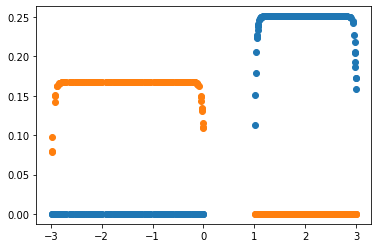

In [26]:
for i in range(bpas.num_components):
    plt.scatter(inp.data.numpy(), yout.data.numpy()[i])

In [33]:
bpas.means.data, bpas.vars.data, bpas.powrs.data, bpas.pi.data

(tensor([ 2.0093, -1.4844]),
 tensor([0.9906, 0.6628]),
 tensor([20.0098, 20.0097]),
 tensor([0.5000, 0.5000]))

In [28]:
yout

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [29]:
torch.sum(yout)

tensor(82.0878, grad_fn=<SumBackward0>)

### Appriximate the area under the curve

In [30]:
mini, maxi = inp.min(), inp.max()
diff = maxi-mini

xs = torch.linspace(mini-diff, maxi+diff, steps=100000, dtype=torch.float32)

In [31]:
### for gaussian
ys = gaus(xs).data
width = xs[1:]-xs[:-1]
height = (ys[:-1]+ys[1:])/2
# height = ys[:-1]

areas = width*height
area = areas.sum()
area

tensor(1.0000)

In [32]:
### for bandpass
ys = bpas(xs).data
width = xs[1:]-xs[:-1]
height = (ys[:-1]+ys[1:])/2

areas = width*height
area = areas.sum()
area

tensor(1.0000)